In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pymongo import MongoClient

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_validate

from collections import Counter
import pprint

In [5]:
client = MongoClient()
db = client['yelp']
# user = db['user']
bus = db['business']
# rev = db['review']

# Data Summary

* \# Countries: 3

    * US
    * Canada
    * UK

* \# Cities: 1200

* \# States: 36

Non-US State Codes:
    * AB (Canada)
    * BC (Canada)
    * DUR (Canada)
    * ON (Canada)
    * QC (Canada)
    * BAS (UK)
    * CON (UK)
    * DOW (UK)
    * XGL (UK)
    * XGM (UK)
    * XWY (UK)

* \# Businesses: 192,609

* \# Users: 1,637,138


## Reviews
* \# Reviews: 6,685,900

* Total words (original dataset): 742,598,084

* Unique words (postprocessing): 

* Avg words/review: 111

Reviews are given a star rating of 1-5. I grouped these into positive (4-5 stars) and negative (1-3 stars) reviews. These classes are not too unbalanced at [[??????]]

## Models

#### Naive Bayes: 
* Accuracy:  84.80%
* Precision: 88.44%
* Recall:    88.48%

In [70]:
print('Records in user: {}'.format(user.count_documents({})))
print('Records in bus:  {}'.format(bus.count_documents({})))
print('Records in rev:  {}'.format(rev.count_documents({})))

Records in user: 1637138
Records in bus:  192609
Records in rev:  6685900


In [77]:
# bus.distinct("state")
# bus.find_one()
# for doc in bus.find({"state": "XWY"}):
#     pprint.pprint(doc)

In [32]:
for business in bus.find({}, {"categories": 1, "_id": 0}, limit=20):
    cats = business['categories'].split(', ')
#     print(cats)
    if 'Food' not in cats and 'Restaurants' not in cats:
        print(cats)
#     else:
#         pprint.pprint(business)

['Insurance', 'Financial Services']
['Golf', 'Active Life']
['Beauty & Spas', 'Hair Salons']
['Plumbing', 'Shopping', 'Local Services', 'Home Services', 'Kitchen & Bath', 'Home & Garden', 'Water Heater Installation/Repair']
['Shipping Centers', 'Couriers & Delivery Services', 'Local Services', 'Printing Services']
['Hair Salons', 'Hair Stylists', 'Barbers', "Men's Hair Salons", 'Cosmetics & Beauty Supply', 'Shopping', 'Beauty & Spas']
['Nail Salons', 'Beauty & Spas', 'Day Spas']
['Local Services', 'Professional Services', 'Computers', 'Shopping', 'Home Services', 'IT Services & Computer Repair', 'Internet Service Providers', 'Web Design']
['Fitness & Instruction', 'Active Life', 'Yoga']
['Bars', 'Nightlife', 'Pubs', 'Barbers', 'Beauty & Spas', 'Irish Pub']
['Hair Stylists', 'Beauty & Spas', 'Hair Salons', "Men's Hair Salons"]
['Trainers', 'Health & Medical', 'Active Life', 'Physical Therapy', 'Gyms', 'Fitness & Instruction']
['Event Planning & Services', 'Photographers', 'Professional 

In [5]:
print(user.find_one())

{'_id': ObjectId('5e38340c9a6a0b2983468f5e'), 'user_id': 'bc8C_eETBWL0olvFSJJd0w', 'name': 'David', 'review_count': 16, 'yelping_since': '2013-10-04 00:16:10', 'useful': 28, 'funny': 8, 'cool': 10, 'elite': '', 'friends': '4N-HU_T32hLENLntsNKNBg, pSY2vwWLgWfGVAAiKQzMng, lwhksSpgIyeYZor_HlN93w, v281gE-nk3jozr_5hWFAug, V7XFwm0baX37HRIduHmrXw, haSh72Q0MsQZUpWPeVgp0Q, bLbSNkLggFnqwNNzzq-Ijw, EKnCY7Tfxts4dexPrz63OQ, u_wqt9RshdZsoj8ikLqoEQ, J8FKQM1yvbwoKcuWRNh1yw, S9tC7Bp2sOLF_nwH-ksiIg, vNGs6_DP7ZbtPwX7finVIQ, 1IQ_d1RuMj8iIpcF2CDohA, WJqVJqhh7vNX51xLHEMEoQ, 5OllWsrKJsYo3XQK6siRKA', 'fans': 0, 'average_stars': 3.71, 'compliment_hot': 0, 'compliment_more': 0, 'compliment_profile': 0, 'compliment_cute': 0, 'compliment_list': 0, 'compliment_note': 1, 'compliment_plain': 0, 'compliment_cool': 0, 'compliment_funny': 0, 'compliment_writer': 0, 'compliment_photos': 0}


In [77]:
def load_subsample(collection, n_rows, new_collection):
    "Creates a new collection from a subset of the original dataset."
    
    r_samp = collection.aggregate([{"$sample": {"size": n_rows}}])

    for doc in r_samp:
        new_collection.insert_one(doc)

In [6]:
user_50k = db['user_50k']
rev_50k = db['rev_50k']
bus_10k = db['bus_10k']

In [81]:
# Creating smaller samples for first pass

load_subsample(user, 50000, user_50k)
load_subsample(rev, 50000, rev_50k)
load_subsample(bus, 10000, bus_10k)

In [82]:
rev_50k.count()

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: count is deprecated. Use estimated_document_count or count_documents instead. Please note that $where must be replaced by $expr, $near must be replaced by $geoWithin with $center, and $nearSphere must be replaced by $geoWithin with $centerSphere
  """Entry point for launching an IPython kernel.


50000

In [7]:
sample = rev_50k.find({}, limit=3)
print(list(sample))

[{'_id': ObjectId('5e38379a23e45989b9f8d6a6'), 'review_id': 'SW4MOF-LNsaO3fu5m7wKdg', 'user_id': 'uUdz50968e_R3k1LExcgYw', 'business_id': '148d7J-cFejkhYV89y3Jsg', 'stars': 2.0, 'useful': 2, 'funny': 0, 'cool': 0, 'text': "Okay it's hard only putting two stars, but I think the price you pay is ridiculous. They charge you a pretty decent chunk of money for 2 people, and you have to ride with 2 other complete strangers...unless you want to cough up some more cash for a private gondola, AND you're also encouraged to tip them. Plus they take pictures of you, but expect you to pay $22 for ONE picture...yeah no. Anyway, the ride was maybe 10 minutes, we went on the outdoor one. It was a really nice day out and I thought it was neat how they sang to you and the Venetian is gorgeous, but still the price is crazy for what you get. I would say if you have the money, go for it, it's nice but not worth the price for the amount of time you get and sitting with people you don't know.", 'date': '2013

In [8]:
bus_10k.find_one()

{'_id': ObjectId('5e383703125c8d82671516e1'),
 'business_id': 'FDh2zdQhhSNbTlKOag1Yiw',
 'name': 'Booster Juice',
 'address': '11674 Sarcee Trail NW, Unit 200',
 'city': 'Calgary',
 'state': 'AB',
 'postal_code': 'T3R 0A1',
 'latitude': 51.1570605,
 'longitude': -114.1595529,
 'stars': 4.0,
 'review_count': 5,
 'is_open': 1,
 'attributes': {'RestaurantsPriceRange2': '2',
  'BusinessParking': "{'garage': False, 'street': False, 'validated': False, 'lot': False, 'valet': False}"},
 'categories': 'Juice Bars & Smoothies, Food',
 'hours': None}

In [60]:
# Get categories by count for all businesses
cursor = bus.find({}, {"_id": 0, "categories": 1})
categories = Counter()
for row in cursor:
    cats = row['categories']
    if cats:
        cats = cats.split(', ')
        
        if 'Bars' in cats or 'Nightlife' in cats:
            categories.update(['Bars & Nightlife'])
        elif 'Food' in cats or 'Restaurants' in cats:
            categories.update(['Food'])
        elif 'Shopping' in cats:
            categories.update(['Shopping'])
        elif 'Beauty & Spas' in cats or 'Hair Salons' in cats or 'Nail Salons' in cats \
             or 'Hair Removal' in cats:
            categories.update(['Beauty & Spas'])
        elif 'Health & Medical' in cats or 'Doctors' in cats or 'Dentists' in cats:
            categories.update(['Health & Medical'])
        elif 'Automotive' in cats or 'Auto Repair' in cats:
            categories.update(['Automotive'])
        elif 'Active Life' in cats or 'Fitness & Instruction' in cats:
            categories.update(['Active Life'])
        else:
#             categories.update(cats)
            categories.update(['Other'])
    else:
#         categories.update(['None'])
        categories.update(['Other'])

len(categories)

8

In [61]:
categories.most_common(20)

[('Food', 65500),
 ('Other', 38755),
 ('Shopping', 28509),
 ('Beauty & Spas', 16592),
 ('Bars & Nightlife', 13095),
 ('Health & Medical', 12030),
 ('Automotive', 11495),
 ('Active Life', 6633)]

In [43]:
df = pd.DataFrame(list(rev_50k.find({}, {
                                        "review_id": 1,
                                        "user_id": 1,
                                        "stars": 1,
                                        "text": 1})))
def sentiment_mapper_binomial(x):
    if x >= 4.0:
        return 'Positive'
    else:
        return 'Negative'


def sentiment_mapper_multinomial(x):
    if x > 3.0:
        return 'Positive'
    elif x == 3.0:
        return 'Neutral'
    else:
        return 'Negative'

df['sentiment_binom'] = df['stars'].apply(sentiment_mapper_binomial)
df['sentiment_multi'] = df['stars'].apply(sentiment_mapper_multinomial)

In [45]:
df.head()

,_id,review_id,stars,text,user_id,sentiment_binom,sentiment_multi
0,5e38379a23e45989b9f8d6a6,SW4MOF-LNsaO3fu5m7wKdg,2.0,"Okay it's hard only putting two stars, but I t...",uUdz50968e_R3k1LExcgYw,Negative,Negative
1,5e38381d23e45989b93319d1,RQLpnu49uvMlz1f3GA9WZA,5.0,Kind of an interesting place - I think it remi...,tI7hrrkhSHbDzXFf_awgKQ,Positive,Positive
2,5e38374023e45989b9d0e943,qMTb4sNMlJVyRlJup1Sj5w,5.0,I visit Jerry often and believe he serves up o...,jgbQAX6KihBLyjGw_hCD-g,Positive,Positive
3,5e38374a23e45989b9d5bb0a,jDCkVChVxJg09Jb187ECBQ,3.0,After hearing nothing but good things about th...,pOz8G2ezXNRx-yCyRi-0Dg,Negative,Neutral
4,5e3837a023e45989b9fb6f63,B2zN4SmUGCy3mkGMNxz8pg,1.0,It's cute inside and much bigger than it looks...,os3Q5QS-pkxpIwVeeTB3kA,Negative,Negative


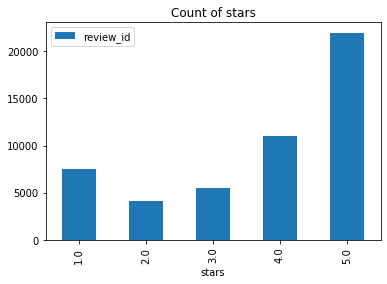

In [46]:
_ = df[['stars', 'review_id']].groupby('stars').count().plot(kind='bar', title='Count of stars')

In [52]:
# Vectorize corpus
tf = TfidfVectorizer(stop_words='english', max_features=5000)
X = tf.fit_transform(df['text'])
y_binom = df['sentiment_binom']
y_multi = df['sentiment_multi']

# X_train, X_test, y_train, y_test = train_test_split(X, y)

In [48]:
# Make models

mnb = MultinomialNB()
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
# gb0 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100)
# gb1 = GradientBoostingClassifier(learning_rate=0.3, n_estimators=200)

models = [mnb, rf]
# mnb.fit(X_train, y_train)

# mnb.score(X_test, y_test)

In [49]:
def train_and_score(model, X, y, scoring=None):
    scores = cross_validate(model, X, y, scoring, cv=3)
    del scores['fit_time']
    del scores['score_time']
    
    for k, v in scores.items():
        avg_v = np.mean(v)
        scores[k] = avg_v
    return scores

In [51]:
# scoring = ['precision_macro', 'recall_macro']

for model in models:
    print(model.__class__.__name__, ": ", train_and_score(model, X, y_binom))
    
# Model results with 10,000 words:

MultinomialNB :  {'test_score': 0.8471000122779255}
RandomForestClassifier :  {'test_score': 0.8615800382900298}


In [53]:
for model in models:
    print(model.__class__.__name__, ": ", train_and_score(model, X, y_binom))
    
# Model results with 5,000 words:

MultinomialNB :  {'test_score': 0.8486600122791735}
RandomForestClassifier :  {'test_score': 0.8613400238895498}


In [71]:
print(train_and_score(gb0, X, y))
print(train_and_score(gb1, X, y))

{'test_score': 0.7887200561216593}
{'test_score': 0.8111801937880251}
